# **Extreme Weather Analysis**

Imports essential libraries for analysis and visualization, then sets key
configuration variables, including file paths, date formats, and the minimum duration for a streak.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm

# ---------- CONFIG ----------
THRESHOLD_CSV = "threshold.csv"
STATION_CSV   = "station.csv"
DAILY_CSV     = "daily_weather.csv"   # rename if needed
DAYFIRST = True
STREAK_MIN_LENGTH = 3

Reads the three CSV files (thresholds, station details, and daily weather data) into Pandas DataFrames for further cleaning and analysis.

In [2]:
# ---------- 1) LOAD & CLEAN ----------
threshold_df = pd.read_csv(THRESHOLD_CSV)
station_df   = pd.read_csv(STATION_CSV)
daily_df     = pd.read_csv(DAILY_CSV)

Cleans and prepares the data — it standardizes column names, converts dates and numeric fields, merges station info into the weather data, and adds year/month columns for easier analysis.

In [3]:
# Standardize column names
for df in [threshold_df, station_df, daily_df]:
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_", regex=False)

# Parse dates
daily_df["date"] = pd.to_datetime(daily_df["date"], errors="coerce", dayfirst=DAYFIRST)

# Numeric conversion
for col in ["tmax_f","tmin_f","wspd_mph","precipitation_in"]:
    if col in daily_df.columns:
        daily_df[col] = pd.to_numeric(daily_df[col], errors="coerce")

# Merge stations
if "station_id" in daily_df.columns and "station_id" in station_df.columns:
    weather_df = daily_df.merge(station_df, on="station_id", how="left")
else:
    weather_df = daily_df.copy()

# Add time parts
weather_df["year"]  = weather_df["date"].dt.year
weather_df["month"] = weather_df["date"].dt.month

print("✅ Data cleaned")
display(weather_df.head())


✅ Data cleaned


,weather_id,station_id,date,tmax_f,tmin_f,wspd_mph,precipitation_in,name,latitude,longitude,elevation,year,month
0,1,1,2023-07-01,95.2,75.1,12.0,0.00,Sample Station,40.7128,-74.006,10.0,2023,7
1,2,1,2023-07-02,88.5,70.3,8.5,0.10,Sample Station,40.7128,-74.006,10.0,2023,7
2,3,1,2023-07-03,92.0,71.0,21.3,0.00,Sample Station,40.7128,-74.006,10.0,2023,7
3,4,1,2023-07-04,85.6,65.2,15.8,0.00,Sample Station,40.7128,-74.006,10.0,2023,7
4,5,1,2023-07-05,97.1,77.0,10.2,0.05,Sample Station,40.7128,-74.006,10.0,2023,7


Shows a quick summary of the cleaned dataset, helping to check column types, missing values, and overall structure before analysis.

In [4]:
# ---------- 2) EDA ----------
print("\n=== Info ===")
display(weather_df.info())



=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   weather_id        370 non-null    int64         
 1   station_id        370 non-null    int64         
 2   date              370 non-null    datetime64[ns]
 3   tmax_f            370 non-null    float64       
 4   tmin_f            370 non-null    float64       
 5   wspd_mph          370 non-null    float64       
 6   precipitation_in  370 non-null    float64       
 7   name              370 non-null    object        
 8   latitude          370 non-null    float64       
 9   longitude         370 non-null    float64       
 10  elevation         370 non-null    float64       
 11  year              370 non-null    int32         
 12  month             370 non-null    int32         
dtypes: datetime64[ns](1), float64(7), int32(2), int64(2), object(1)
me

None

Summarizes the main weather variables numerically, giving a quick snapshot of central tendency, spread, and ranges.

In [5]:
print("\n=== Summary statistics ===")
display(weather_df[["tmax_f","tmin_f","wspd_mph","precipitation_in"]].describe())



=== Summary statistics ===


,tmax_f,tmin_f,wspd_mph,precipitation_in
count,370.000000,370.000000,370.000000,370.000000
mean,19.963243,18.263784,5.148108,0.034459
std,51.269059,52.445734,21.233156,0.560701
min,-69.000000,-88.000000,-30.000000,-0.950000
25%,-25.000000,-25.000000,-13.000000,-0.450000
50%,22.000000,18.500000,5.000000,0.000000
75%,65.000000,62.000000,23.000000,0.550000
max,109.000000,120.000000,40.000000,0.950000


Checks data completeness by showing the number of missing values per column.

In [6]:
print("\n=== Missing values ===")
display(weather_df.isna().sum())



=== Missing values ===


,0
weather_id,0
station_id,0
date,0
tmax_f,0
tmin_f,0
wspd_mph,0
precipitation_in,0
name,0
latitude,0
longitude,0


Shows how many daily records exist for each year, helping to spot gaps or uneven coverage in the dataset.

In [7]:
print("\nRows per year:")
display(weather_df["year"].value_counts().sort_index())



Rows per year:


,count
year,
2023,370


Turns threshold rules into flags, adds them to the dataset, and then shows how often each extreme condition occurred.

In [8]:
# ---------- 3) APPLY THRESHOLDS ----------
op_map = {">":np.greater,"<":np.less,">=":np.greater_equal,"<=":np.less_equal,"==":np.equal}
extreme_cols = []
for _, row in threshold_df.iterrows():
    var, op, val, name = row["variable"], row["operator"], row["value"], row["name"]
    if var in weather_df.columns and op in op_map:
        col = f"is_{name.lower().replace(' ','_')}"
        weather_df[col] = op_map[op](weather_df[var], val)
        extreme_cols.append(col)
weather_df["is_extreme"] = weather_df[extreme_cols].any(axis=1)
print("\n=== Threshold flags summary ===")
display(weather_df[extreme_cols + ["is_extreme"]].sum())



=== Threshold flags summary ===


,0
is_hot_day,28
is_cold_day,211
is_windy_day,105
is_extreme,265


Creates an interactive line chart of daily maximum temperature with a 7-day moving average, including zoom/range controls and a date slider for easier exploration.

In [9]:
# ---------- 4) INTERACTIVE VISUALIZATIONS ----------
# Daily Max Temp with 7-day MA
df_ts = weather_df.loc[weather_df["date"].notna(), ["date","tmax_f"]].sort_values("date").copy()
if "tmax_f" in df_ts and not df_ts.empty:
    df_ts["tmax_f_ma7"] = df_ts["tmax_f"].rolling(7, min_periods=1).mean()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_ts["date"], y=df_ts["tmax_f"],
                             mode="lines", name="Daily Max Temp"))
    fig.add_trace(go.Scatter(x=df_ts["date"], y=df_ts["tmax_f_ma7"],
                             mode="lines", name="7-day MA"))
    fig.update_layout(
        title="Daily Max Temperature (°F) with 7-day MA",
        xaxis=dict(rangeselector=dict(buttons=list([
            dict(count=7, label="7d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(step="all")
        ])), rangeslider=dict(visible=True), type="date"),
        yaxis_title="Max Temp (°F)"
    )
    fig.show()

Creates an interactive bar chart where the user can toggle between seeing the number of extreme weather days per year or per month, using on-chart buttons.

In [10]:
# Extreme Days per Year vs Month
agg_year = weather_df.groupby("year", dropna=True)["is_extreme"].sum().reset_index(name="extreme_days")
agg_month = weather_df.groupby("month", dropna=True)["is_extreme"].sum().reset_index(name="extreme_days")

fig = go.Figure()
fig.add_trace(go.Bar(x=agg_year["year"], y=agg_year["extreme_days"], name="By Year", visible=True))
fig.add_trace(go.Bar(x=agg_month["month"], y=agg_month["extreme_days"], name="By Month", visible=False))

fig.update_layout(
    title="Extreme Weather Days — Year vs Month",
    margin=dict(t=100),   # extra space for title + buttons
    updatemenus=[dict(
        type="buttons",
        direction="right",
        x=0.5, xanchor="center",   # center align
        y=1.1, yanchor="bottom",   # put below the title
        buttons=[
            dict(label="By Year", method="update",
                 args=[{"visible":[True, False]}, {"xaxis":{"title":"Year"}}]),
            dict(label="By Month", method="update",
                 args=[{"visible":[False, True]}, {"xaxis":{"title":"Month"}}]),
        ]
    )]
)

fig.show()


Computes and plots the number of extreme days in each 7-day window, showing short-term clusters of extreme weather with an interactive time slider.

In [11]:
# Rolling 7-day extreme sum
if "is_extreme" in weather_df.columns:
    s = (
        weather_df.loc[weather_df["date"].notna(), ["date", "is_extreme"]]
        .sort_values("date").set_index("date")["is_extreme"]
    )
    roll = s.rolling("7D", min_periods=1).sum().reset_index(name="extreme_7d_sum")
    fig = px.line(roll, x="date", y="extreme_7d_sum", title="Rolling 7-Day Sum of Extreme Days")
    fig.update_layout(yaxis_title="# extreme days (last 7 days)",
                      xaxis=dict(rangeslider=dict(visible=True), type="date"))
    fig.show()


Groups consecutive flagged days into streaks by splitting whenever dates aren’t exactly 1 day apart, then keeps only streaks at least STREAK_MIN_LENGTH days long (default 3).

In [12]:
# ---------- 5) STREAKS ----------
def find_streaks(df, flag_col, min_length=3, date_col="date"):
    if flag_col not in df.columns: return pd.DataFrame()
    d = df.loc[df[flag_col] & df[date_col].notna(), [date_col]].sort_values(date_col)
    if d.empty: return pd.DataFrame()
    gap = d[date_col].diff().dt.days.ne(1).cumsum()
    streaks = (d.groupby(gap)
                 .agg(start_date=(date_col,"min"), end_date=(date_col,"max"),
                      length_days=(date_col,"count"))
                 .reset_index(drop=True))
    return streaks[streaks["length_days"]>=min_length]

hot_flag  = next((c for c in weather_df.columns if "hot" in c), None)
cold_flag = next((c for c in weather_df.columns if "cold" in c), None)

heatwave_streaks = find_streaks(weather_df, hot_flag, STREAK_MIN_LENGTH) if hot_flag else pd.DataFrame()
coldsnap_streaks = find_streaks(weather_df, cold_flag, STREAK_MIN_LENGTH) if cold_flag else pd.DataFrame()

print("\n=== Heatwave Streaks (≥3 days) ===")
display(heatwave_streaks.head(10))



=== Heatwave Streaks (≥3 days) ===


,start_date,end_date,length_days


Previews the detected cold snap streaks (minimum 3 days long), just like the earlier preview for heatwave streaks.

In [13]:
print("\n=== Cold Snap Streaks (≥3 days) ===")
display(coldsnap_streaks.head(10))


=== Cold Snap Streaks (≥3 days) ===


,start_date,end_date,length_days
4,2023-01-18,2023-01-21,4
5,2023-01-24,2023-01-26,3
8,2023-02-04,2023-02-06,3
11,2023-02-19,2023-02-23,5
13,2023-03-01,2023-03-04,4
19,2023-03-22,2023-03-25,4
23,2023-04-06,2023-04-08,3
27,2023-04-20,2023-04-24,5
28,2023-04-26,2023-04-29,4
30,2023-05-05,2023-05-11,7


Visualizes the distribution of streak lengths for heatwaves and cold snaps, so you can see whether most streaks are short or if long streaks are common.

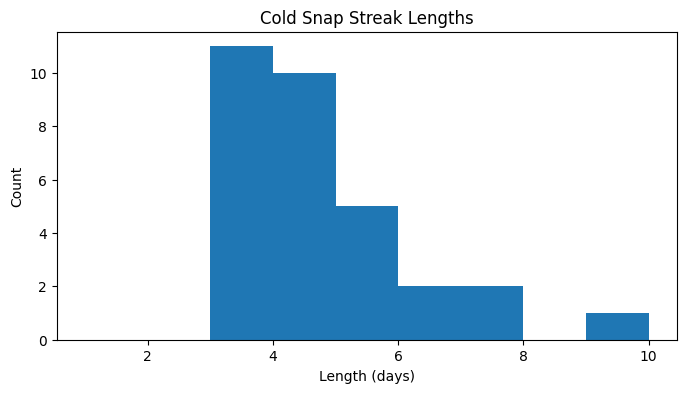

In [14]:
# Histograms of streak lengths
if not heatwave_streaks.empty:
    heatwave_streaks["length_days"].plot(kind="hist",
        bins=range(1, int(heatwave_streaks["length_days"].max())+2),
        title="Heatwave Streak Lengths", figsize=(8,4))
    plt.xlabel("Length (days)"); plt.ylabel("Count"); plt.show()

if not coldsnap_streaks.empty:
    coldsnap_streaks["length_days"].plot(kind="hist",
        bins=range(1, int(coldsnap_streaks["length_days"].max())+2),
        title="Cold Snap Streak Lengths", figsize=(8,4))
    plt.xlabel("Length (days)"); plt.ylabel("Count"); plt.show()


Computes headline metrics (coverage, hottest/coldest days, extreme-day stats) and extracts the longest heatwave/cold-snap streak, then displays everything in a tidy table.

In [15]:
# ---------- 6) KPI SUMMARY (better table) ----------
def longest_streak_info(streak_df, label):
    if streak_df.empty:
        return {f"longest_{label}_length":0, f"longest_{label}_start":None, f"longest_{label}_end":None}
    top = streak_df.sort_values("length_days", ascending=False).iloc[0]
    return {f"longest_{label}_length":int(top["length_days"]),
            f"longest_{label}_start":top["start_date"].date().isoformat(),
            f"longest_{label}_end":top["end_date"].date().isoformat()}

total_days = int(weather_df["date"].notna().sum())
hot_row = weather_df.loc[weather_df["tmax_f"].idxmax()] if "tmax_f" in weather_df else None
cold_row = weather_df.loc[weather_df["tmin_f"].idxmin()] if "tmin_f" in weather_df else None

kpi = {
    "Total days in dataset": total_days,
    "Hottest day": hot_row["date"].date().isoformat() if hot_row is not None else None,
    "Max temperature (°F)": float(hot_row["tmax_f"]) if hot_row is not None else None,
    "Coldest day": cold_row["date"].date().isoformat() if cold_row is not None else None,
    "Min temperature (°F)": float(cold_row["tmin_f"]) if cold_row is not None else None,
    "Extreme days (count)": int(weather_df["is_extreme"].sum()),
    "Extreme days (%)": round(100*weather_df["is_extreme"].mean(),2),
    "Longest heatwave (days)": longest_streak_info(heatwave_streaks,"heatwave")["longest_heatwave_length"],
    "Heatwave start": longest_streak_info(heatwave_streaks,"heatwave")["longest_heatwave_start"],
    "Heatwave end": longest_streak_info(heatwave_streaks,"heatwave")["longest_heatwave_end"],
    "Longest cold snap (days)": longest_streak_info(coldsnap_streaks,"coldsnap")["longest_coldsnap_length"],
    "Cold snap start": longest_streak_info(coldsnap_streaks,"coldsnap")["longest_coldsnap_start"],
    "Cold snap end": longest_streak_info(coldsnap_streaks,"coldsnap")["longest_coldsnap_end"],
}

print("\n=== KPI Summary ===")
kpi_table = pd.DataFrame(list(kpi.items()), columns=["Metric", "Value"])
display(kpi_table)



=== KPI Summary ===


,Metric,Value
0,Total days in dataset,370
1,Hottest day,2023-01-22
2,Max temperature (°F),109.0
3,Coldest day,2023-05-09
4,Min temperature (°F),-88.0
5,Extreme days (count),265
6,Extreme days (%),71.62
7,Longest heatwave (days),0
8,Heatwave start,None
9,Heatwave end,None


Aggregates data by month and plots two trends: Average max temperature per month (line chart), Total extreme days per month (bar chart).

In [19]:
# ---------- 7) MONTHLY TRENDS (Overall + Per Station) ----------
monthly = weather_df.loc[weather_df["date"].notna()].copy()
monthly["ym"] = monthly["date"].values.astype("datetime64[M]")

m_tmax = monthly.groupby("ym")["tmax_f"].mean().reset_index(name="mean_tmax_f")
m_ext  = monthly.groupby("ym")["is_extreme"].sum().reset_index(name="extreme_days")

if not m_tmax.empty:
    fig = px.line(m_tmax, x="ym", y="mean_tmax_f", markers=True,
                  title="Monthly Mean Max Temperature — Overall")
    fig.update_layout(yaxis_title="Mean Max Temp (°F)")
    fig.show()

if not m_ext.empty:
    fig = px.bar(m_ext, x="ym", y="extreme_days",
                 title="Monthly Extreme Days — Overall")
    fig.update_layout(yaxis_title="# Extreme Days")
    fig.show()


In [24]:
# ---------- MONTHLY DISTRIBUTION & SHARES----------
import calendar

# Prep: month label (Jan–Dec) in correct order
monthly_day = weather_df.dropna(subset=["date","tmax_f"]).copy()
monthly_day["month_num"] = monthly_day["date"].dt.month
monthly_day["month_lbl"] = monthly_day["month_num"].apply(lambda m: calendar.month_abbr[m])
month_order = list(calendar.month_abbr)[1:]  # ["Jan",..., "Dec"]

# If station metadata exists, keep it; else create a placeholder for "All"
has_station = ("station_id" in monthly_day.columns) and ("name" in monthly_day.columns)
if not has_station:
    monthly_day["station_id"] = "ALL"
    monthly_day["name"] = "All stations"

# ------- BOX PLOT: Daily Max Temp distribution by month (dropdown: All vs. per-station) -------
# Build one set of 12 box traces per option (All + each station)
# Note: if you have MANY stations, this can create many traces; consider filtering top-N.

# Build “All stations” frame
all_df = monthly_day.copy()
# If you *do* have station_id, the "All" view aggregates across stations:
all_df["view_key"] = "All stations"

# Build per-station frames
station_map = (monthly_day.dropna(subset=["station_id"])
               .drop_duplicates("station_id")
               .set_index("station_id")["name"].to_dict())
station_ids = list(station_map.keys()) if has_station else []

# Create traces
box_traces = []
trace_groups = []  # which view each trace belongs to
views = ["All stations"] + [station_map[sid] for sid in station_ids]

def add_box_traces(src_df, view_label):
    # add 12 boxes (one per month)
    for m in month_order:
        yvals = src_df.loc[src_df["month_lbl"]==m, "tmax_f"]
        box_traces.append(go.Box(
            x=[m]*len(yvals), y=yvals,
            name=m, boxpoints="outliers", jitter=0.3, whiskerwidth=0.5,
            hovertemplate="<b>%{x}</b><br>Daily Max Temp: %{y:.1f} °F<extra></extra>",
            showlegend=False
        ))
        trace_groups.append(view_label)

# All stations boxes
add_box_traces(all_df, "All stations")

# Per-station boxes
for sid in station_ids:
    df_s = monthly_day.loc[monthly_day["station_id"]==sid].copy()
    add_box_traces(df_s, station_map[sid])

# Visibility: show only first view initially
visible = [g == "All stations" for g in trace_groups]

fig_box = go.Figure(data=box_traces)
# Dropdown buttons toggle which group's 12 traces are visible
buttons = []
for view in views:
    vis = [g == view for g in trace_groups]
    buttons.append(dict(
        label=view,
        method="update",
        args=[{"visible": vis},
              {"title": f"Distribution of Daily Max Temp by Month — {view}",
               "xaxis": {"title": "Month", "categoryorder": "array", "categoryarray": month_order},
               "yaxis": {"title": "Daily Max Temp (°F)"}}]
    ))

fig_box.update_layout(
    title=f"Distribution of Daily Max Temp by Month — {views[0]}",
    updatemenus=[dict(
        type="dropdown", direction="down",
        x=0.02, y=1.15, xanchor="left", yanchor="top",
        showactive=True, buttons=buttons
    )],
    xaxis=dict(categoryorder="array", categoryarray=month_order),
    yaxis_title="Daily Max Temp (°F)",
    margin=dict(t=110),
)
fig_box.show()




In [23]:
# ---------- HEATMAP: % Extreme Days by Month × Year----------
import calendar

ext_df = weather_df.dropna(subset=["date"]).copy()
ext_df["year"] = ext_df["date"].dt.year
ext_df["month_num"] = ext_df["date"].dt.month
ext_df["month_lbl"] = ext_df["month_num"].apply(lambda m: calendar.month_abbr[m])
month_order = list(calendar.month_abbr)[1:]  # Jan..Dec

has_station = ("station_id" in ext_df.columns) and ("name" in ext_df.columns)
if not has_station:
    ext_df["station_id"] = "ALL"
    ext_df["name"] = "All stations"

station_map = (ext_df.drop_duplicates("station_id")
               .set_index("station_id")["name"].to_dict())
station_ids = list(station_map.keys())

# Build one heatmap per station; dropdown toggles visibility
traces, groups = [], []
for sid in station_ids:
    d = ext_df.loc[ext_df["station_id"]==sid].copy()
    d["extreme"] = d["is_extreme"].astype(int)
    # % extreme per year×month
    grid = (d.groupby(["year","month_lbl"])["extreme"]
              .mean().mul(100).reset_index())
    # Ensure full month ordering per year
    pivot = (grid.pivot(index="year", columns="month_lbl", values="extreme")
                  .reindex(columns=month_order).sort_index())
    traces.append(go.Heatmap(
        z=pivot.values, x=pivot.columns, y=pivot.index,
        coloraxis="coloraxis",
        hovertemplate="Year %{y}, %{x}<br>% Extreme: %{z:.1f}%<extra></extra>",
        visible=False,
        name=station_map[sid]
    ))
    groups.append(station_map[sid])

# Show first station by default
if traces:
    traces[0].visible = True
fig_hm = go.Figure(data=traces)

buttons = []
for i, label in enumerate(groups):
    vis = [False]*len(groups); vis[i] = True
    buttons.append(dict(
        label=label, method="update",
        args=[{"visible": vis},
              {"title": f"% Extreme Days — Month × Year Heatmap — {label}",
               "xaxis":{"title":"Month"}, "yaxis":{"title":"Year"}}]
    ))

fig_hm.update_layout(
    title=f"% Extreme Days — Month × Year Heatmap — {groups[0] if groups else 'All'}",
    updatemenus=[dict(type="dropdown", x=0.02, y=1.15, xanchor="left", yanchor="top",
                      direction="down", buttons=buttons, showactive=True)],
    coloraxis=dict(colorscale="Viridis", colorbar_title="% Extreme"),
    margin=dict(t=110)
)
fig_hm.show()
